In [7]:
import cv2, os
import scipy
from skimage.measure import label, regionprops
from skimage import data,color,morphology,feature,measure,draw 
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
from skimage.measure import compare_psnr
import elasticdeform

In [11]:
def get_bbox(img):
    h, w = img.shape
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    r = rmax - rmin
    c = cmax - cmin
    x = np.round((rmax+rmin)/2)
    y = np.round((cmax+cmin)/2)
    x1 = x-256
    x2 = x+256
    y1 = y-256
    y2 = y+256
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y1 < 0:
        y2 += -y1
        y1 = 0
    return np.uint16(y1), np.uint16(x1), np.uint16(y2), np.uint16(x2)


def get_bbox_source(img):
    h, w = img.shape
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    r = rmax - rmin
    c = cmax - cmin
    x = np.round((rmax+rmin)/2)
    y = np.round((cmax+cmin)/2)
    x1 = x-256
    x2 = x+256
    y1 = y-256
    y2 = y+256
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y1 < 0:
        y2 += -y1
        y1 = 0
    return np.uint16(y1), np.uint16(x1), np.uint16(y2), np.uint16(x2)

def get_bool(img, type = 0):
    if type == 0:
        return img == 0
    if type == 1:
        return img == 1

def get_largest_fillhole(binary):
    label_image = label(binary)
    regions = regionprops(label_image)
    area_list = []
    for region in regions:
        area_list.append(region.area)
    if area_list:
        idx_max = np.argmax(area_list)
        binary[label_image != idx_max + 1] = 0
    return scipy.ndimage.binary_fill_holes(np.asarray(binary).astype(int))

def dice_coef(y_true, y_pred):
    smooth = 1e-8
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true*y_true) + np.sum(y_pred*y_pred) + smooth)

def calculate_dice(gt_mask, noise_mask):
    disc_dice = []
    cup_dice = []
    gt_binary = np.zeros((gt_mask.shape[0], gt_mask.shape[1],2))
    noise_binary = np.zeros(( noise_mask.shape[0],  noise_mask.shape[1],2))
    gt_binary[gt_mask < 200] = [1, 0]
    gt_binary[gt_mask < 50] = [1, 1]
    noise_binary[noise_mask < 200] = [1, 0]
    noise_binary[noise_mask < 50] = [1, 1]
    disc_dice = dice_coef(gt_binary[:,:,0], noise_binary[:,:,0])
    cup_dice = dice_coef(gt_binary[:,:,1], noise_binary[:,:,1])
    return disc_dice, cup_dice


50 n0011.bmp
[  0 128 255]
[  0. 128. 255.]


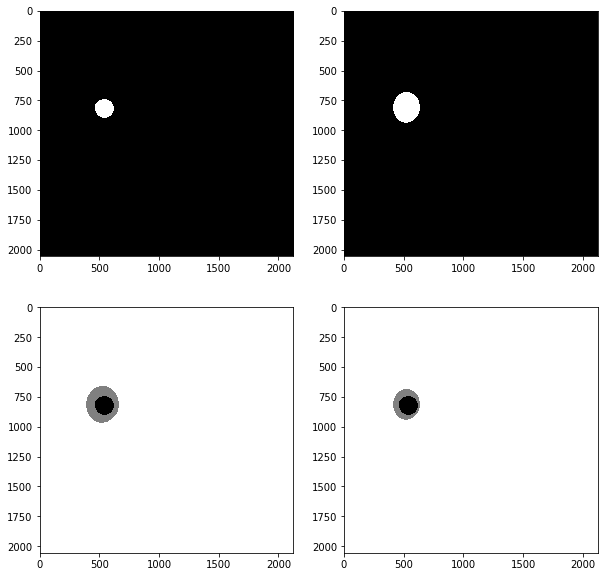

0.8115627430763 1.0
noise ratio: 0.18843725692370006


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/lolitazhang/Desktop/DATA/Drishti-GS/source/level_0.1-0.4/noise_labels_400\\n0011.bmp'

In [9]:
#root = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels'
#save = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/level_0.5-0.7/noise_labels_400'
root = 'C:/Users/lolitazhang/Desktop/DATA/Drishti-GS/source/labels'
save = 'C:/Users/lolitazhang/Desktop/DATA/Drishti-GS/source/level_0.1-0.4/noise_labels_400'
filelist = os.listdir(root)
for i in range(50,100):
    file = filelist[i]
    print(i,file)
    gt_mask = Image.open(os.path.join(root,file))
    gt_mask = np.asarray(gt_mask, np.float32)
    id_mask = np.asarray(gt_mask, np.float32)

    mask_to_id = {0 : 0, 128 : 1, 255:2}
    for k, v in mask_to_id.items():
        id_mask[gt_mask == k] = v
    cup_mask = get_bool(id_mask, 0)
    disc_mask = get_bool(id_mask, 0) + get_bool(id_mask, 1)     
    disc_mask = morphology.binary_erosion(disc_mask, morphology.disk(25)).astype(np.uint8)  # return 0,1 # [20,40]， [25,50]，[30,70]
    #cup_mask = morphology.binary_erosion(cup_mask, morphology.disk(25)).astype(np.uint8)  # return 0,1 #[20,30],[25,40],[30,70]
    #disc_mask = morphology.binary_dilation(disc_mask, morphology.disk(120)).astype(np.uint8)  # return 0,1 # [20,40],[25,80],[40,120]
    #cup_mask = morphology.binary_dilation(cup_mask, morphology.disk(80)).astype(np.uint8)  # return 0,1 # [20,40],[25,50],[40,80]
    output_mask = disc_mask + cup_mask
    output_mask[output_mask ==2] =3
    output_mask[output_mask ==0] =2
    output_mask[output_mask ==3] =0
    id_to_mask = {0 : 255,1 : 128, 2 : 0 }
    for k, v in mask_to_id.items():
        output_mask[output_mask == v] = k
        gt_mask[gt_mask == v] = k
    print(np.unique(output_mask))
    print(np.unique(gt_mask))
    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.imshow(cup_mask,cmap='gray')
    plt.subplot(222)
    plt.imshow(disc_mask,cmap='gray')
    plt.subplot(223)
    plt.imshow(gt_mask,cmap='gray')
    plt.subplot(224)
    plt.imshow(output_mask,cmap='gray')
    plt.show() 
    disc_dice, cup_dice = calculate_dice(gt_mask, output_mask)
    print(disc_dice, cup_dice)
    print('noise ratio:',2-disc_dice-cup_dice)
    output_mask = Image.fromarray(output_mask.astype(np.uint8))
    output_mask.save(os.path.join(save,file.split('.')[0]+'.bmp'))
    with open(os.path.join(save,'noise_label.txt'),"a") as f:
        f.write(file.split('.')[0]+'_erosion_cup.bmp' + '\n')

n0261.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[128 255]
[  0. 128. 255.]
0.3789939892439647 4.1505831569318266e-13
noise ratio: 1.6210060107556203
n0262.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[128 255]
[  0. 128. 255.]
0.715700484556669 2.3892008123277057e-13
noise ratio: 1.284299515443092
n0263.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[128 255]
[  0. 128. 255.]
0.5501047176174345 2.5028783100559387e-13
noise ratio: 1.4498952823823152
n0264.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[  0 128 255]
[  0. 128. 255.]
0.4677589400199964 8.824567596179999e-13
noise ratio: 1.5322410599791212
n0265.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[  0 128 255]
[  0. 128. 255.]
0.8047907643286761 0.9123785979163297
noise ratio: 0.2828306377549943
n0266.bmp
[  0. 128. 255.]
[  0. 255.]
[  0. 255.]
[0 1]
[0 1]
[  0 128 255]
[  0. 128. 255.]
0.8809149751775371 0.2955580865607656
noise ratio: 0.8235269382616972
n0267.bmp
[  0.

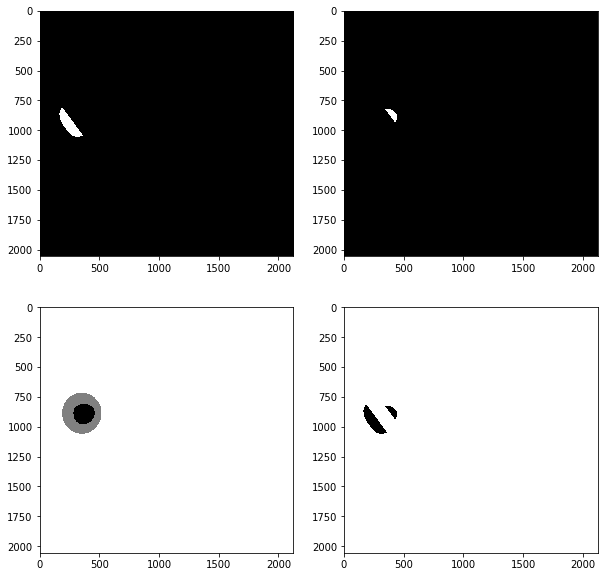

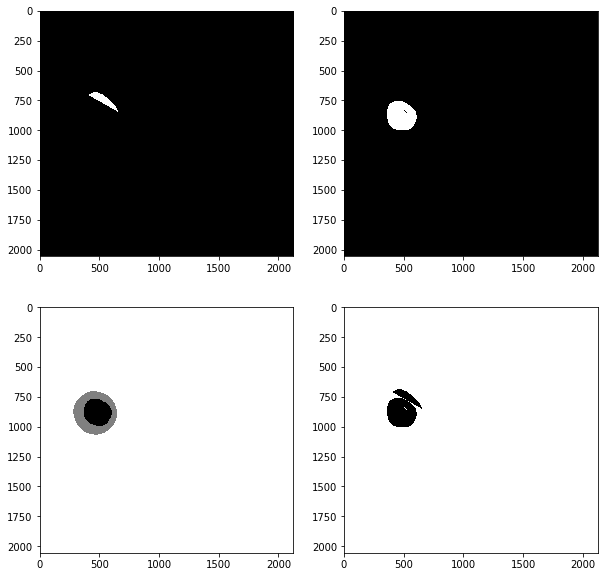

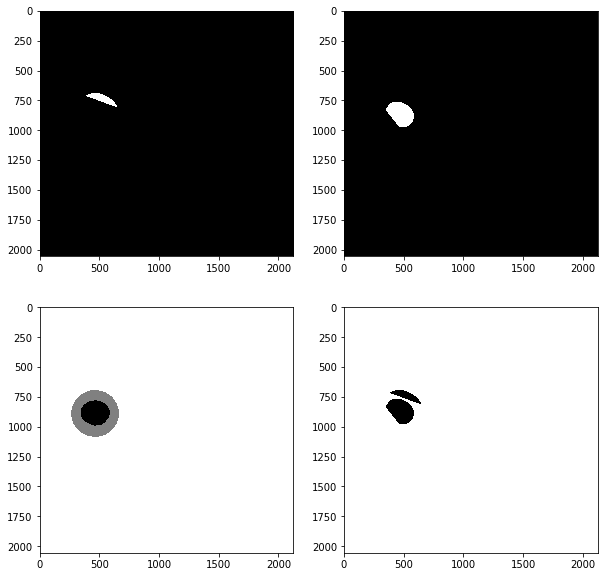

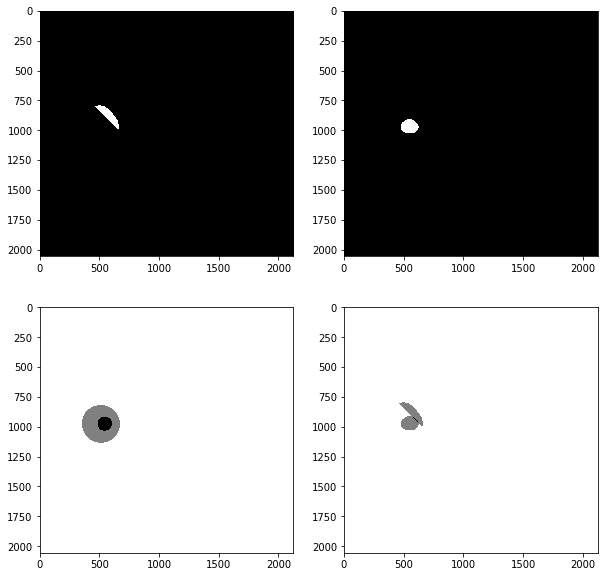

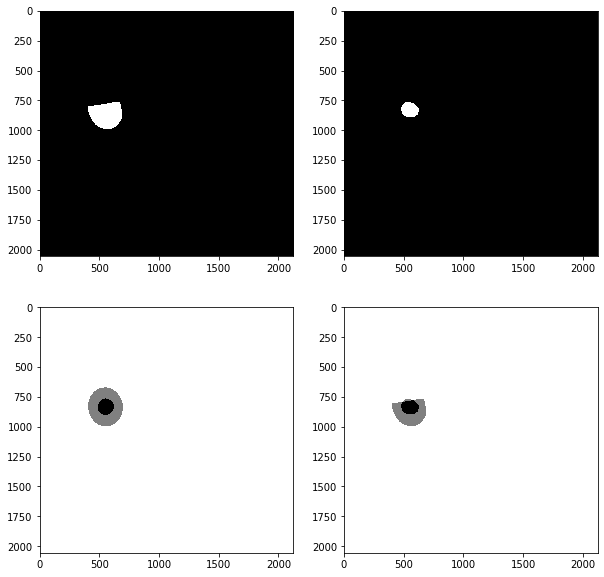

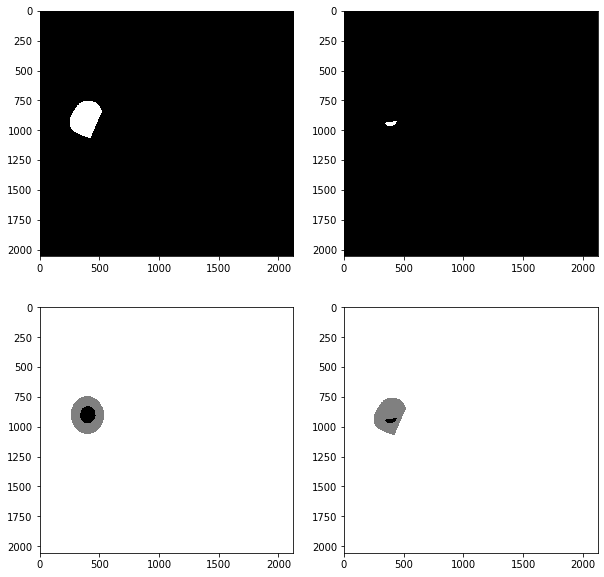

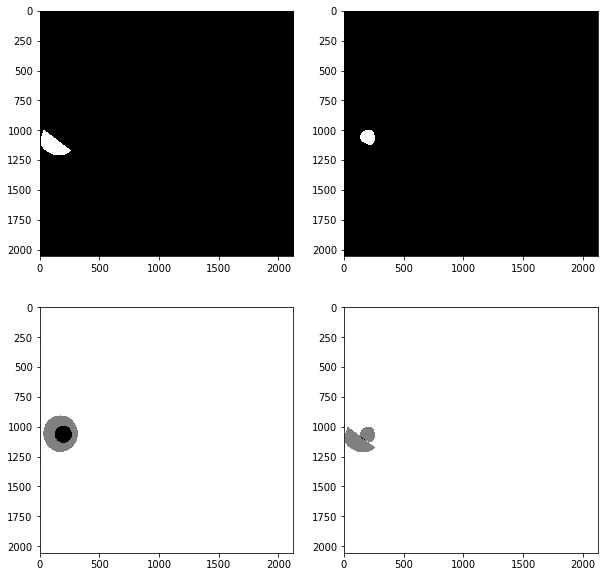

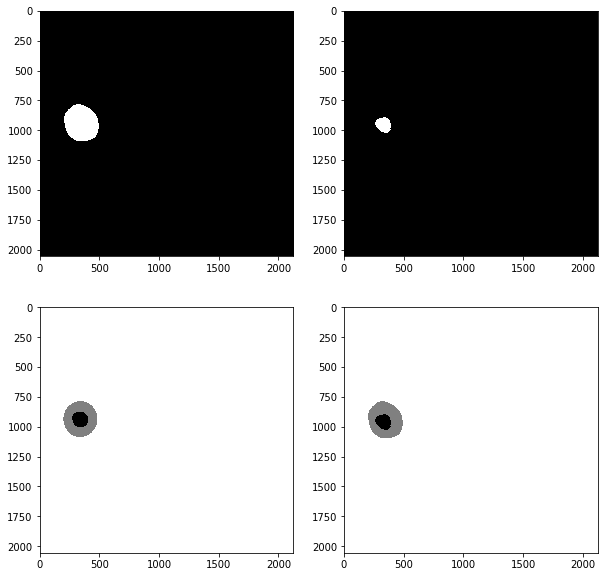

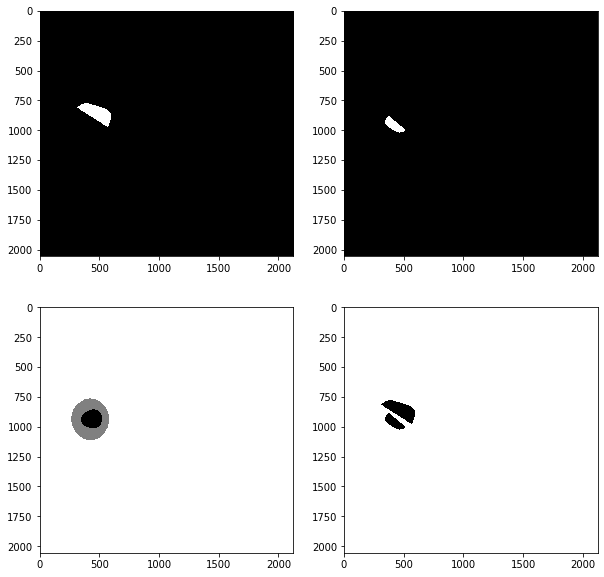

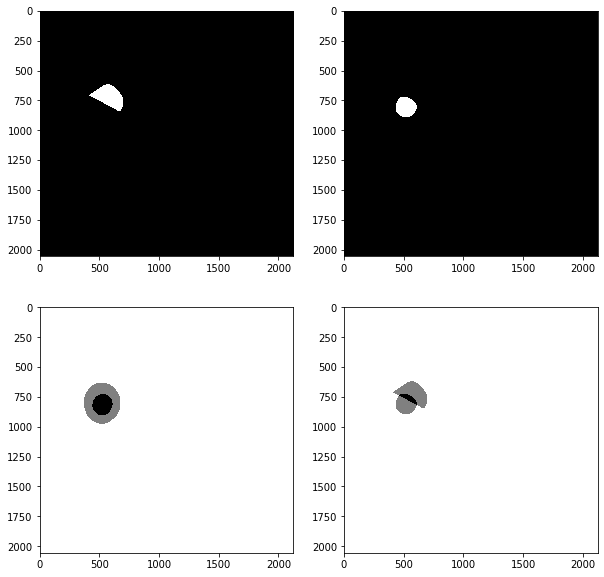

In [48]:
label_root = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/eyesgan/'
save = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/noise_labels'
filelist = os.listdir(os.path.join(label_root,'labels'))
for i in range(300,310):
    file = filelist[i]
    print(file)
    gt_mask =  Image.open(os.path.join(label_root,'labels',file))
    disc_contour = Image.open(os.path.join(label_root,'contour_disc',file))
    cup_contour = Image.open(os.path.join(label_root,'contour_cup',file))
    gt_mask = np.asarray(gt_mask, np.float32)
    disc_contour= np.asarray(disc_contour, np.float32)
    cup_contour= np.asarray(cup_contour, np.float32)
    deformed_disc = elasticdeform.deform_random_grid(disc_contour,sigma=15, points=15, axis=(0, 1))
    deformed_cup = elasticdeform.deform_random_grid(cup_contour,sigma=15, points=15, axis=(0, 1))
    deformed_disc [deformed_disc<128] = 0
    deformed_disc [deformed_disc>128] = 255
    deformed_cup [deformed_cup<128] = 0
    deformed_cup [deformed_cup>128] = 255
    
    print(np.unique(gt_mask))
    print(np.unique(deformed_disc))
    print(np.unique(deformed_cup))
    deformed_disc = np.array(deformed_disc,np.uint8)
    disc_mask = morphology.convex_hull_object(deformed_disc)
    deformed_cup = np.array(deformed_cup,np.uint8)
    cup_mask = morphology.convex_hull_object(deformed_cup)
    disc_mask = get_largest_fillhole(disc_mask)*1
    cup_mask = get_largest_fillhole(cup_mask)*1
    print(np.unique(disc_mask))
    print(np.unique(cup_mask))
    
    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.imshow(disc_mask,cmap='gray')
    plt.subplot(222)
    plt.imshow(cup_mask,cmap='gray')
    
    disc_mask[disc_mask == 255] = 1
    cup_mask[cup_mask == 255] = 1
    output_mask = disc_mask + cup_mask

    id_to_mask = {0 : 255, 1 : 128, 2 :0 }
    for k, v in id_to_mask.items():
        output_mask[output_mask == k] = v
    print(np.unique(output_mask))
    print(np.unique(gt_mask))
    plt.subplot(223)
    plt.imshow(gt_mask,cmap='gray')
    plt.subplot(224)
    plt.imshow(output_mask,cmap='gray')
        
    disc_dice, cup_dice = calculate_dice(gt_mask, output_mask)
    print(disc_dice, cup_dice)
    print('noise ratio:',2-disc_dice-cup_dice)
    output_mask = Image.fromarray(output_mask.astype(np.uint8))
#     output_mask.save(os.path.join(save,file.split('.')[0]+'.bmp'))
#     with open(os.path.join(save,'noise_label.txt'),"a") as f:
#         f.write(file.split('.')[0]+'_dilation_cup.bmp' + '\n')

In [108]:
# import Augmentor
# p = Augmentor.Pipeline("C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels")
# p.random_distortion(probability=1,grid_height=30,grid_width=30,magnitude=70)
# p.sample(400)
# image_path = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels'
# fileList = os.listdir(os.path.join(image_path,'output'))

for name in fileList:
    distort_mask =  Image.open(os.path.join(image_path,'output',name))
    gt_name = image_path + os.sep + name.split('.')[0].split('_')[-1] + '.bmp'
    print(gt_name)
    gt_mask =  Image.open(os.path.join(image_path, gt_name))
    gt_mask = np.asarray(gt_mask, np.float32)
    distort_mask= np.asarray(distort_mask, np.float32)
    disc_dice, cup_dice = calculate_dice(gt_mask, distort_mask)
    print('noise ratio:',2-disc_dice-cup_dice)
    oldname = image_path + os.sep+ 'output'+ os.sep + name
    newname = image_path + os.sep+ 'output'+ os.sep + name.split('.')[0].split('_')[-1] + '.bmp'
    try:
        os.rename(oldname, newname)
    except IOError:
        print("Error: 没有找到文件或读取文件失败")

C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0001.bmp
noise ratio: 0.3273777726642759
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0001.bmp
noise ratio: 0.32424510897972025
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0003.bmp
noise ratio: 0.5110967720453825
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0004.bmp
noise ratio: 0.759464668165589
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0005.bmp
noise ratio: 0.33668364918821747
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0007.bmp
noise ratio: 0.26633083394550705
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0007.bmp
noise ratio: 0.3379823968604485
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0008.bmp
noise ratio: 0.5537850429711311
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0008.bmp
noise ratio: 0.34969812823211477
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\g0008.

C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0108.bmp
noise ratio: 1.020829135170406
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0112.bmp
noise ratio: 0.4772412247538893
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0115.bmp
noise ratio: 0.530487506978445
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0117.bmp
noise ratio: 0.40625497569292734
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0120.bmp
noise ratio: 0.4885460946711472
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0122.bmp
noise ratio: 0.3415014484488095
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0122.bmp
noise ratio: 0.6332186236537121
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0123.bmp
noise ratio: 0.45444653140310287
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0123.bmp
noise ratio: 0.350320726703073
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0124.bmp
noise ratio: 0.699881

C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0264.bmp
noise ratio: 0.6007483811999332
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0265.bmp
noise ratio: 0.3424869448619928
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0266.bmp
noise ratio: 0.44733797738004466
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0266.bmp
noise ratio: 0.41472085233821243
Error: 没有找到文件或读取文件失败
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0269.bmp
noise ratio: 0.40574662240766424
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0270.bmp
noise ratio: 0.3327294111131873
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0272.bmp
noise ratio: 0.5343770105238104
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0273.bmp
noise ratio: 0.309355097296101
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0274.bmp
noise ratio: 0.385893256374915
C:/Users/lolitazhang/Desktop/DATA/Refuge/source/labels\n0275.bmp
noise ratio: 0.4254

n0199
n0155


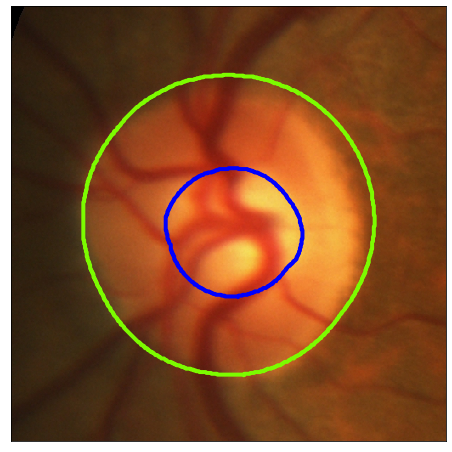

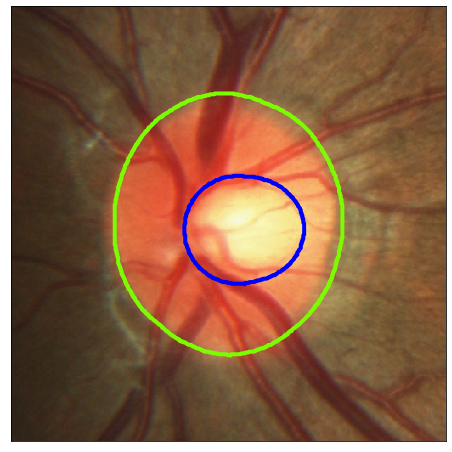

In [12]:
import scipy
#V0305 V0329 V0335 V0345 V0353 V0356 V0369 V0371 V0376 V0381
root = 'E:/dataset-new'
file = ['n0039','n0199','n0155']

for name in file[1:3]:
    print(name)
    name_img =  name.split('.')[0]  + '.jpg'
    name_label = name.split('.')[0] + '.bmp'
    name_result = name.split('.')[0] + '.png'

    image = Image.open(osp.join(root,'source', 'images/%s' % name_img)).convert('RGB')
    label = Image.open(osp.join(root,'source','labels/%s' % name_label))

    
    s = np.asarray(label, np.float32)
    s_copy = np.zeros(s.shape, dtype=np.float32)
    ind = {0: 1, 128: 1}
    for k, v in ind.items():
        s_copy[s == k] = v

    bbox = get_bbox_source(s_copy)
    image = image.crop(bbox)
    label = label.crop(bbox)

    
    gt_mask = np.asarray(label, np.float32)


    id_to_mask = {0 : 255,1 : 128, 2 : 0 }
    for k, v in mask_to_id.items():
        gt_mask[gt_mask == v] = k


    #检测cup的轮廓
    mask = gt_mask
    fig, ax1 = plt.subplots(1,1,figsize=(8,8))
    ax1.imshow(image,plt.cm.gray)
    contours = measure.find_contours(mask, 0.5)
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='blue') # 'lightblue, blue'
    #检测disc的轮廓
    #mask = beal_disc_mask 
    ind = {128: 0}
    for k, v in ind.items():
        mask[mask == k] = v
    contours = measure.find_contours(mask, 0.5)    
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='lawngreen') #'red, lawngreen' 
    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])

n0039
[  0 128 255]
[  0. 128. 255.]


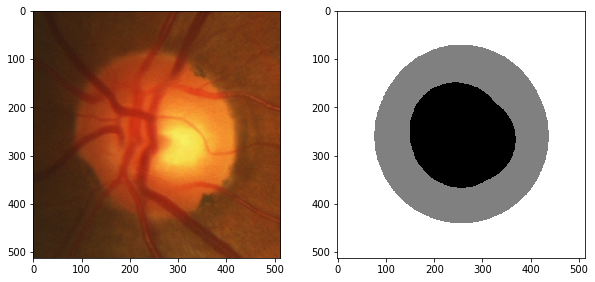

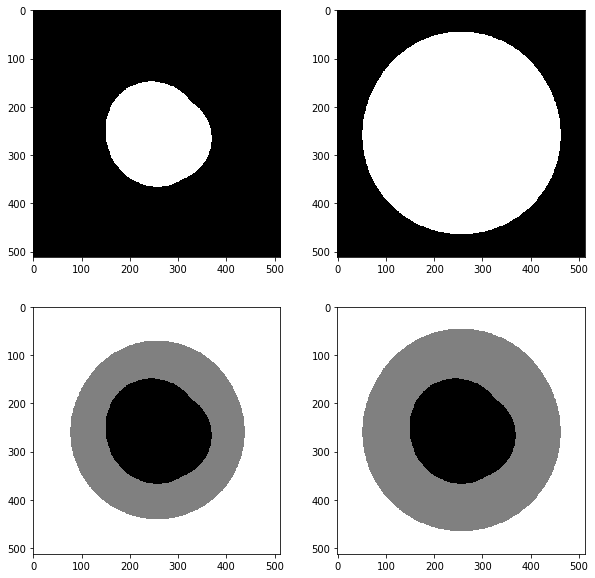

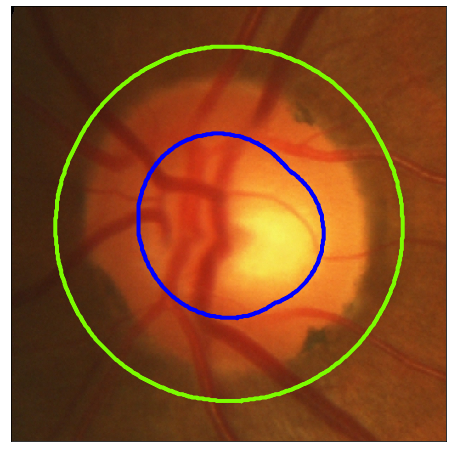

In [175]:
import os
import os.path as osp
import numpy as np
from PIL import Image


def get_bbox(img):
    h, w = img.shape
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    r = rmax - rmin
    c = cmax - cmin
    x = np.round((rmax+rmin)/2)
    y = np.round((cmax+cmin)/2)
    x1 = x-256
    x2 = x+256
    y1 = y-256
    y2 = y+256
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y1 < 0:
        y2 += -y1
        y1 = 0
    return np.uint16(y1), np.uint16(x1), np.uint16(y2), np.uint16(x2)


def get_bbox_source(img):
    h, w = img.shape
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    r = rmax - rmin
    c = cmax - cmin
    x = np.round((rmax+rmin)/2)
    y = np.round((cmax+cmin)/2)
    x1 = x-256
    x2 = x+256
    y1 = y-256
    y2 = y+256
    if x1 < 0:
        x2 += -x1
        x1 = 0
    if y1 < 0:
        y2 += -y1
        y1 = 0
    return np.uint16(y1), np.uint16(x1), np.uint16(y2), np.uint16(x2)

root = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source'
file = ['n0039','n0199','n0155']
img = Image.open(os.path.join(root, 'images', file[1]+'.jpg'))
label = Image.open(os.path.join(root, 'labels', file[1]+'.bmp'))
for name in file[0:1]:
    print(name)
    name_img = name.split('.')[0] + '.jpg'
    name_label = name.split('.')[0] + '.bmp'
    image = Image.open(osp.join(root, "images/%s" % name_img)).convert('RGB')
    label = Image.open(osp.join(root, "labels/%s" % name_label))
    ind = {0: 1, 128: 1}
    s = np.asarray(label, np.float32)
    s_copy = np.zeros(s.shape, dtype=np.float32)
    for k, v in ind.items():
        s_copy[s == k] = v
    bbox = get_bbox_source(s_copy)
    image = image.crop(bbox)
    label = label.crop(bbox)
    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.imshow(image)
    plt.subplot(222)
    plt.imshow(label,cmap='gray')
    
    gt_mask = np.asarray(label, np.float32)
    id_mask = np.asarray(gt_mask, np.float32)
    mask_to_id = {0 : 0, 128 : 1, 255:2}
    for k, v in mask_to_id.items():
        id_mask[gt_mask == k] = v
    cup_mask = get_bool(id_mask, 0)
    disc_mask = get_bool(id_mask, 0) + get_bool(id_mask, 1)     
    #disc_mask = morphology.binary_erosion(disc_mask, morphology.disk(50)).astype(np.uint8)  # return 0,1 # [20,40]， [25,50]，[30,70]
    #cup_mask = morphology.binary_erosion(cup_mask, morphology.disk(40)).astype(np.uint8)  # return 0,1 #[20,30],[25,40],[30,70]
    disc_mask = morphology.binary_dilation(disc_mask, morphology.disk(25)).astype(np.uint8)  # return 0,1 # [20,40],[25,80],[40,120]
    #cup_mask = morphology.binary_dilation(cup_mask, morphology.disk(60)).astype(np.uint8)  # return 0,1 # [20,40],[25,50],[40,80]
    output_mask = disc_mask + cup_mask
    output_mask[output_mask ==2] =3
    output_mask[output_mask ==0] =2
    output_mask[output_mask ==3] =0
    id_to_mask = {0 : 255,1 : 128, 2 : 0 }
    for k, v in mask_to_id.items():
        output_mask[output_mask == v] = k
        gt_mask[gt_mask == v] = k
    print(np.unique(output_mask))
    print(np.unique(gt_mask))
    plt.figure(figsize = (10,10))
    plt.subplot(221)
    plt.imshow(cup_mask,cmap='gray')
    plt.subplot(222)
    plt.imshow(disc_mask,cmap='gray')
    plt.subplot(223)
    plt.imshow(gt_mask,cmap='gray')
    plt.subplot(224)
    plt.imshow(output_mask,cmap='gray')
    plt.show() 
    fig, ax1 = plt.subplots(1,1,figsize=(8,8))
    ax1.imshow(image,plt.cm.gray)
    #检测cup的轮廓
    contours = measure.find_contours(output_mask, 0.5)
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='blue')
    #检测disc的轮廓
    ind = {128: 0}
    for k, v in ind.items():
        output_mask[output_mask == k] = v
    contours = measure.find_contours(output_mask, 0.5)    
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='lawngreen')    
    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])

[]

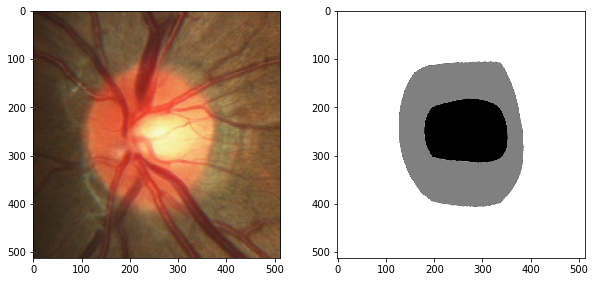

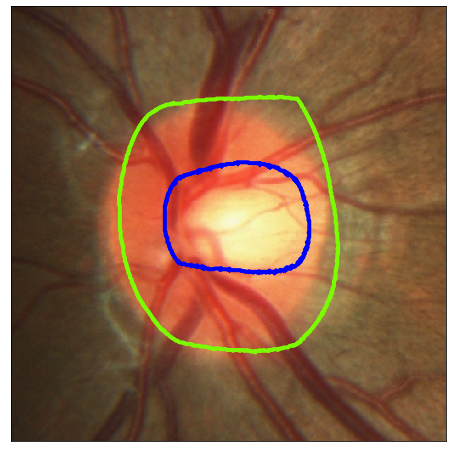

In [150]:
import os
from skimage.measure import label, regionprops
from skimage import data,color,morphology,feature,measure,draw 
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
from skimage.measure import compare_psnr

root =  'C:/Users/lolitazhang/Desktop/DATA/Refuge/source'
img = Image.open(os.path.join(root, 'images','n0155.jpg'))
label =  Image.open(os.path.join(root,'test/output','1.bmp'))

ind = {0: 1, 128: 1}
s = np.asarray(label, np.float32)
s_copy = np.zeros(s.shape, dtype=np.float32)
for k, v in ind.items():
    s_copy[s == k] = v
bbox = get_bbox_source(s_copy)
image = img.crop(bbox)
label = label.crop(bbox)
plt.figure(figsize = (10,10))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(label,cmap='gray')
#print(np.unique(output_mask))
fig, ax1 = plt.subplots(1,1,figsize=(8,8))
ax1.imshow(image,plt.cm.gray)

label = np.array(label, np.float32)

#检测cup的轮廓
contours = measure.find_contours(label, 0.5)
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=4, color='blue')

label[label<200]=0
#检测disc的轮廓
contours = measure.find_contours(label, 0.5)    
for n, contour in enumerate(contours):
    ax1.plot(contour[:, 1], contour[:, 0], linewidth=4, color='lawngreen') 
ax1.axis('image')
ax1.set_xticks([])
ax1.set_yticks([])

In [129]:
save = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/level_0.5-0.7/noise_labels_0.9'
filelist = os.listdir(save)
for file in filelist:
    with open(os.path.join(save,'noise_label.txt'),"a") as f:
        f.write(file.split('.')[0] + '\n')

In [141]:
save = 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/level_0.5-0.7/noise_labels_0.1'
filelist = os.listdir(save)
for name in filelist:
    print(name)
    label = Image.open(osp.join(save, "%s" % name))
    label = np.array(label)
    print(np.unique(label))
    label[label<128]=0
    label[label>128]=255
    print(np.unique(label))
    label = Image.fromarray(label.astype(np.uint8))
    label.save(os.path.join(save,name))

g0001.bmp
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 

[  0 128 255]
n0312.bmp
[  0 128 255]
[  0 128 255]
n0313.bmp
[  0 128 255]
[  0 128 255]
n0314.bmp
[  0 128 255]
[  0 128 255]
n0315.bmp
[  0 128 255]
[  0 128 255]
n0316.bmp
[  0 128 255]
[  0 128 255]
n0317.bmp
[  0 128 255]
[  0 128 255]
n0318.bmp
[  0 128 255]
[  0 128 255]
n0319.bmp
[  0 128 255]
[  0 128 255]
n0320.bmp
[  0 128 255]
[  0 128 255]
n0321.bmp
[  0 128 255]
[  0 128 255]
n0322.bmp
[  0 128 255]
[  0 128 255]
n0323.bmp
[  0 128 255]
[  0 128 255]
n0324.bmp
[  0 128 255]
[  0 128 255]
n0325.bmp
[  0 128 255]
[  0 128 255]
n0326.bmp
[  0 128 255]
[  0 128 255]
n0327.bmp
[  0 128 255]
[  0 128 255]
n0328.bmp
[  0 128 255]
[  0 128 255]
n0329.bmp
[  0 128 255]
[  0 128 255]
n0330.bmp
[  0 128 255]
[  0 128 255]
n0331.bmp
[  0 128 255]
[  0 128 255]
n0332.bmp
[  0 128 255]
[  0 128 255]
n0333.bmp
[  0 128 255]
[  0 128 255]
n0334.bmp
[  0 128 255]
[  0 128 255]
n0335.bmp
[  0 128 255]
[  0 128 255]
n0336.bmp
[  0 128 255]
[  0 128 255]
n0337.bmp
[  0 128 255]
[  0 128 255

OSError: cannot identify image file 'C:/Users/lolitazhang/Desktop/DATA/Refuge/source/level_0.5-0.7/noise_labels_0.1\\noise_label.txt'

In [161]:
import Augmentor
p = Augmentor.Pipeline("C:/Users/lolitazhang/Desktop/DATA/Refuge/source/test")
p.random_distortion(probability=1,grid_height=30,grid_width=50,magnitude=35)
p.sample(1)

Initialised with 1 image(s) found.
Output directory set to C:/Users/lolitazhang/Desktop/DATA/Refuge/source/test\output.

Processing <PIL.Image.Image image mode=L size=2124x2056 at 0x17D80703048>: 100%|███| 1/1 [00:00<00:00,  6.89 Samples/s]


019
[0. 1.]
[0. 1.]
[  0. 128. 255.]


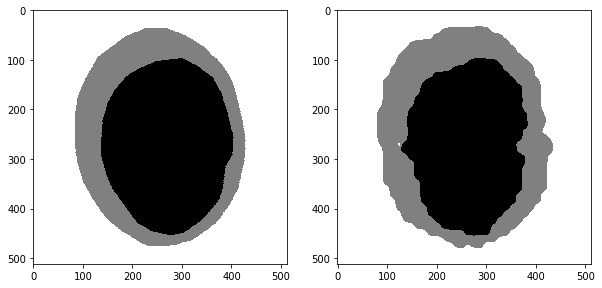

086
[0. 1.]
[0. 1. 2.]
[  0. 128. 255.]


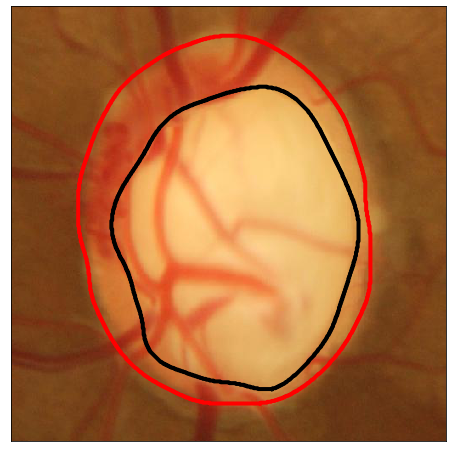

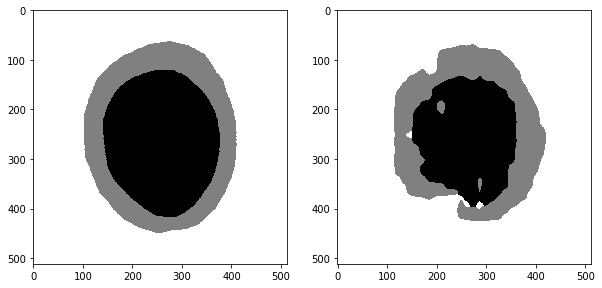

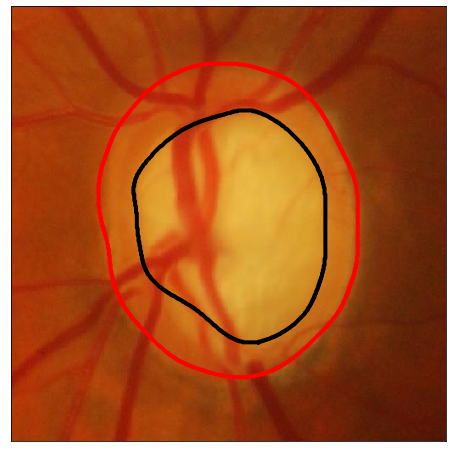

In [189]:
#结果图展示
import os.path as osp
import scipy
#V0305 V0329 V0335 V0345 V0353 V0356 V0369 V0371 V0376 V0381
#root = 'E:/dataset-new'
#file = ['V0329','V0322','V0333','V0400','V0305','V0335','V0345','V0353','V0356','V0369','V0371','V0376','V0381']
file = ['019','086','025']
root = 'C:/Users/lolitazhang/Desktop/DATA/Drishti-GS'
posal_path = 'D:/Projects/pOSAL-master-with-data/data/refuge-new/test/'
#beal_path= 'D:/Projects/BEAL-master/results/results-new/prediction'
beal_path= 'D:/Projects/BEAL-master/results/results-new/0.5-0.7_prediction_0.5'
#beal_path= 'D:/Projects/BEAL-master/results/results-new/prediction'
bdl_path= 'E:/dataset-new/BDL/bdl_0.5-0.7'
#bdl_path= 'E:/dataset-new/BDL'

for name in file[0:2]:
    print(name)
    name_img = 'drishtiGS_'+ name + '.jpg'
    name_label = 'drishtiGS_'+name+ '.bmp'
    name_result = 'drishtiGS_'+name + '.png'
    
#     name_img =  name.split('.')[0]  + '.jpg'
#     name_label = name.split('.')[0] + '.bmp'
#     name_result = name.split('.')[0] + '.png'

    image = Image.open(osp.join(root,'test', 'images/%s' % name_img)).convert('RGB')
    label = Image.open(osp.join(root,'test','labels/%s' % name_label))
    result = Image.open(osp.join(root,'level_0.5-0.7/color_%s' % name_result))
    #result = Image.open(osp.join(root,'results_ssl_test-old/color_%s' % name_result))
    #result = Image.open(osp.join(root,'0.5-0.7_results_0.5/color_%s' % name_result))
    posal = Image.open(osp.join(posal_path,'0.5-0.7_noise_0.5/%s' % name_result))
    #posal = Image.open(osp.join(posal_path,'OSAL_epoch100/%s' % name_result))
    beal_cup = Image.open(osp.join(beal_path,'cup/%s' % name_img))
    #beal_cup = Image.open(osp.join(beal_path,'cup/V0309.jpg'))
    beal_disc = Image.open(osp.join(beal_path,'disc/%s' % name_img))
    #beal_disc = Image.open(osp.join(beal_path,'disc/V0309.jpg'))
    bdl = Image.open(osp.join(bdl_path,'color_%s' % name_result))
    
    s = np.asarray(label, np.float32)
    s_copy = np.zeros(s.shape, dtype=np.float32)
    ind = {0: 1, 128: 1}
    for k, v in ind.items():
        s_copy[s == k] = v

    bbox = get_bbox_source(s_copy)
    image = image.crop(bbox)
    label = label.crop(bbox)
    result = result.crop(bbox)
    beal_cup = beal_cup.crop(bbox)
    beal_disc = beal_disc.crop(bbox)
    bdl = bdl.crop(bbox)
    
    gt_mask = np.asarray(label, np.float32)
    result_mask = np.asarray(result, np.float32)
    posal_mask = np.asarray(posal, np.float32)
    beal_cup_mask = np.asarray(beal_cup, np.float32)
    beal_disc_mask = np.asarray(beal_disc, np.float32)
    bdl_mask = np.asarray(bdl, np.float32)
    for i in range(5):
        beal_disc_mask = scipy.signal.medfilt2d(beal_disc_mask, 5)
        beal_cup_mask = scipy.signal.medfilt2d(beal_cup_mask, 5)
        bal_disc_mask = scipy.signal.medfilt2d(beal_disc_mask, 5)
        beal_cup_mask = scipy.signal.medfilt2d(beal_cup_mask, 5)
    print(np.unique(beal_cup_mask))    
    print(np.unique(beal_disc_mask)) 
    bdl_mask[bdl_mask==1]=0
    bdl_mask[bdl_mask==3]=2

    id_to_mask = {0 : 255,1 : 128, 2 : 0 }
    for k, v in mask_to_id.items():
        #result_mask[result_mask == v] = k
        gt_mask[gt_mask == v] = k
        bdl_mask[bdl_mask == v] = k
        beal_cup_mask[beal_cup_mask == v] = k
        beal_disc_mask[beal_disc_mask == v] = k
#     print(np.unique(beal_cup_mask))    
#     print(np.unique(beal_disc_mask))  
    print(np.unique(result_mask))
#     print(np.unique(gt_mask))
#     print(np.unique(bdl_mask))
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(gt_mask,cmap='gray')
    plt.subplot(122)
    plt.imshow(bdl_mask,cmap='gray')
    plt.show() 
    fig, ax1 = plt.subplots(1,1,figsize=(8,8))
    ax1.imshow(image,plt.cm.gray)
    #检测cup的轮廓
    mask = result_mask
    #mask = gt_mask
    #mask = posal_mask 
    #mask = beal_cup_mask 
    #mask = bdl_mask 
#     ind = {1: 0}
#     for k, v in ind.items():
#         mask[mask == k] = v
    contours = measure.find_contours(mask, 0.5)
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='black') # 'lightblue, blue'
    #检测disc的轮廓
    #mask = beal_disc_mask 
    ind = {128: 0}
    for k, v in ind.items():
        mask[mask == k] = v
    contours = measure.find_contours(mask, 0.5)    
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=4,color='red') #'red, lawngreen' 
    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])